# Configuration

Import here the libraries you will need

In [337]:
!pip install pmdarima prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [338]:
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf


Define the required functions

In [339]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(10,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [340]:
def test_stationarity(timeseries, N):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=N).mean()
    rolstd = timeseries.rolling(window=N).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [341]:
def interpret_dftest(dftest, th):
    print('ADF Statistic: %f' % dftest[0])
    print('p-value: %f' % dftest[1])
    if dftest[1] <= th: print('We can reject the null hypothesis. Time series is stationary')
    else: print('Time series is not stationary')
    print('Critical Values:')
    for key, value in dftest[4].items():
        print('\t%s: %.3f' % (key, value))

In [342]:
def forecast_accuracy(predicted, real):
    mape = np.mean(np.abs(predicted - real)/np.abs(real))  # MAPE

    return({'MAPE':mape})

In [343]:
def obtain_order_model(ts):
    # Obtain ACF and PCSF
    lag_acf = acf(ts, nlags=20, fft = True)
    lag_pacf = pacf(ts, nlags=20, method='ols')

    plt.figure(figsize=(8,4))
    #Plot ACF:
    plt.subplot(121)
    plt.plot(lag_acf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

In [344]:
def model_summary_results(model_fitted):
  # Model summary
  print(model_fitted.summary())

  # Model residuals
  residuals = pd.DataFrame(model_fitted.resid)
  residuals = residuals.reset_index()
  residuals = residuals.drop(['new_date'], axis=1)
  residuals.columns = ['residuals']

  # Plot
  plt.figure(figsize=(10,4))
  plt.subplot(121)

  plt.plot(residuals)
  plt.title('Residuals')
  plt.subplot(122)
  sns.kdeplot(data=residuals, x="residuals")
  plt.title('Density')
  plt.show()


In [345]:
def forecasting(model_fitted, n_preds, data_test, title, value_column='value'):
  # Predict
  forecast = model_fitted.forecast(n_preds, alpha=0.05)

  # Convert predictions to series
  fc_series = pd.Series(forecast, index=data_test.index)

  # Plot
  plt.figure(figsize=(10, 4), dpi=100)
  plt.plot(data_train[value_column], label='Training')
  plt.plot(data_test[value_column], label='Actual')
  plt.plot(fc_series, label='Forecast')
  plt.title(title)
  plt.legend(loc='upper left', fontsize=8)
  plt.show()

Define the variables you will use later

In [349]:
path = 'aemet_year_month.csv'

# Final exercise

Load the ts from the folder data_for_final_exercise and answer the following questions.

In [350]:
data = pd.read_csv(path, sep=';')
data.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,new_date
0,29634.3,6141.5,6955.3,9319.2,8591.2,2013-05-01
1,21886.2,5392.1,5400.1,5654.4,6314.1,2013-06-01
2,12508.8,1863.3,801.9,3006.0,7135.5,2013-07-01
3,13331.8,2288.7,2483.6,3927.3,5233.9,2013-08-01
4,23053.8,4188.3,4840.3,6940.1,8206.9,2013-09-01


Get the shape of the dataframe and the types

In [351]:
data.shape

(64, 6)

In [352]:
data.dtypes

rain_all      float64
rain_00_06    float64
rain_06_12    float64
rain_12_18    float64
rain_18_24    float64
new_date       object
dtype: object

Basic statistics.
We'll use the column `rain_all` as the time series value.

In [353]:
data.describe()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
count,64.000000,64.000000,64.000000,64.000000,64.000000
mean,34067.514062,8216.856250,8401.934375,9504.381250,9700.815625
std,19266.121783,5184.353285,5542.373036,5233.150279,4676.360236
min,5660.700000,1024.500000,801.900000,1334.400000,1806.300000
25%,18885.525000,4150.875000,3769.125000,5046.700000,6022.875000
50%,32614.300000,7813.250000,7924.700000,8791.500000,9362.550000
75%,44732.075000,11479.900000,12649.750000,12666.775000,12311.700000
max,102026.000000,24350.900000,25285.300000,28059.500000,26929.100000


We don't have any null values.

In [354]:
data.isnull().sum()

rain_all      0
rain_00_06    0
rain_06_12    0
rain_12_18    0
rain_18_24    0
new_date      0
dtype: int64

### 1.- Which is the **format** of the date variable? What **frequency** does it have?

The `new_date` column is our time column, and it has the format `YYYY-MM-DD`, with a monthly frequency.

We will format this column and we will make it the dataset index.

In [355]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv(path, sep=';', parse_dates=['new_date'], index_col='new_date', date_parser=dateparse)
data.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2
2013-06-01,21886.2,5392.1,5400.1,5654.4,6314.1
2013-07-01,12508.8,1863.3,801.9,3006.0,7135.5
2013-08-01,13331.8,2288.7,2483.6,3927.3,5233.9
2013-09-01,23053.8,4188.3,4840.3,6940.1,8206.9


In [356]:
data.tail()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2018-04-01,60092.5,14305.5,12576.2,16327.1,17446.3
2018-05-01,42106.1,7781.7,6800.1,13933.0,14194.8
2018-06-01,34203.3,6657.4,6270.9,10628.7,11041.5
2018-07-01,16561.4,2762.6,2897.9,4817.6,6240.4
2018-08-01,14669.9,2365.9,1757.9,4890.7,6025.2


We have rain metrics for 5 years, from May 2013 to August 2018.

Now, checking the index and verifying this is set to the first day of the month, to make it easier to work later.

In [357]:
data.index

DatetimeIndex(['2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
      

We set up the frequence, explicitly.

In [358]:
data = data.asfreq('MS')
data.index

DatetimeIndex(['2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01',
               '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
      

Our timeseries column is `rain_all`, that is totalizing the individual rain metrics.

In [359]:
data.head()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
new_date,,,,,
2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2
2013-06-01,21886.2,5392.1,5400.1,5654.4,6314.1
2013-07-01,12508.8,1863.3,801.9,3006.0,7135.5
2013-08-01,13331.8,2288.7,2483.6,3927.3,5233.9
2013-09-01,23053.8,4188.3,4840.3,6940.1,8206.9


If you plot the data, do you observe **a trend or seasonal behavior**?

There is no a clear trend, and the series follows a seasonal component.

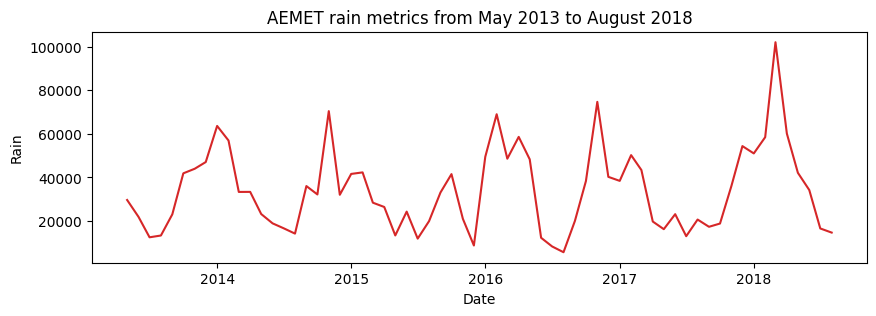

In [361]:
plot_df(data, x=data.index, y=data.rain_all, title='AEMET rain metrics from May 2013 to August 2018', ylabel='Rain')

Let's obtain barplot/boxplot for trend and seasonal components.

We need some extra variables, year and month, to calculate them we are going to get a new version of the dataframe without the time index.

In [364]:
data_for_plot = data.copy()
data_for_plot.reset_index(inplace=True)
data_for_plot.head(1)

,new_date,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24
0,2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2


We calculate year and month separately, so we are able to plot trend on a yearly basis, and seasonality on a monthly basis.

In [365]:
data_for_plot['year'] = [d.year for d in data_for_plot.new_date]
data_for_plot['month'] = [d.strftime('%b') for d in data_for_plot.new_date]
data_for_plot.head(1)

,new_date,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,year,month
0,2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2,2013,May


We get the plots and obtain some conclussions:

* **Trend:** There is no a clear trend with a behaviour which increases or decreases, we have inconstant values with fluctuations per time periods. There are similar values every 2 years in 2013, 2015 and 2017, and higher values in 2014, 2016 and 2018, with a peak in 2018.
* **Seasonality:** Two peaks (November and February), lower values during summer time, and higher values during winter time.

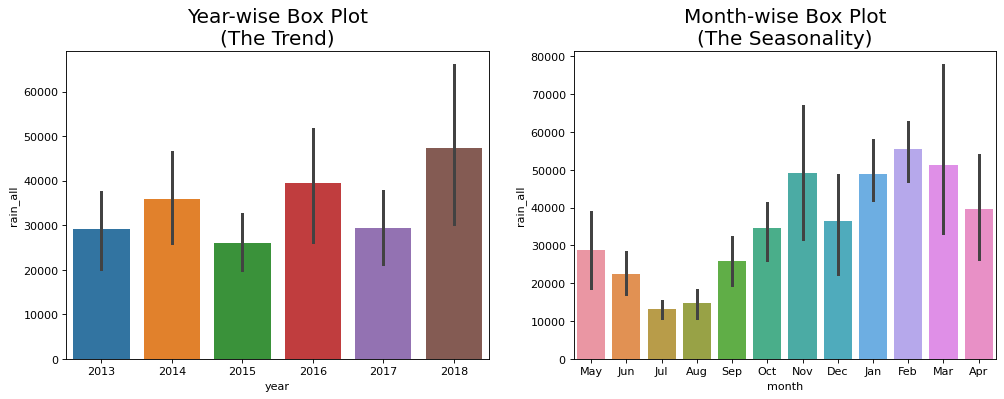

In [366]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), dpi= 80)
sns.barplot(x='year', y='rain_all',
            data=data_for_plot, ax=axes[0])
sns.barplot(x='month', y='rain_all',
            data=data_for_plot)

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

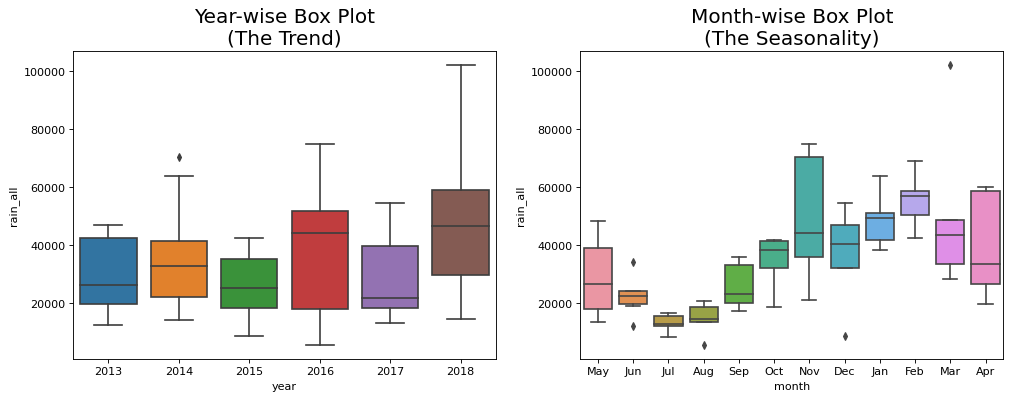

In [367]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), dpi= 80)
sns.boxplot(x='year', y='rain_all', data=data_for_plot, ax=axes[0])
sns.boxplot(x='month', y='rain_all', data=data_for_plot, ax=axes[1])

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18);
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

### 2.- Does the ts follow an **additive or a multiplicative** model?

**If we suppose an additive model:**

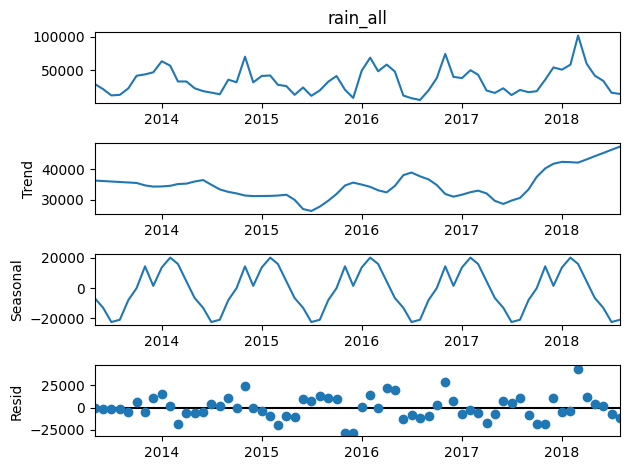

In [368]:
data_add = seasonal_decompose(data['rain_all'], model='additive', extrapolate_trend='freq')
data_add.plot();

We calculate the mean a standard deviation of the resid for the additive model:

In [369]:
data_add.resid.mean(), data_add.resid.std()

(93.5520500410089, 13029.058136799413)

In [370]:
reconstructed_df = pd.concat([
  data_add.trend,
  data_add.seasonal,
  data_add.resid,
  data_add.observed
], axis=1)
reconstructed_df.columns = ['trend', 'seasonal', 'residual', 'actual_values']
reconstructed_df.describe()

,trend,seasonal,residual,actual_values
count,64.000000,64.000000,64.000000,64.000000
mean,34953.415359,-979.453346,93.552050,34067.514062
std,4663.545343,14119.410743,13029.058137,19266.121783
min,26368.429167,-22374.265932,-28476.910450,5660.700000
25%,31718.302083,-12971.041848,-7705.953581,18885.525000
50%,34612.260417,15.450046,-964.988318,32614.300000
75%,36399.536014,13725.131283,8317.404646,44732.075000
max,47508.190438,20240.688783,43755.055084,102026.000000


**If we suppose a multiplicative model:**

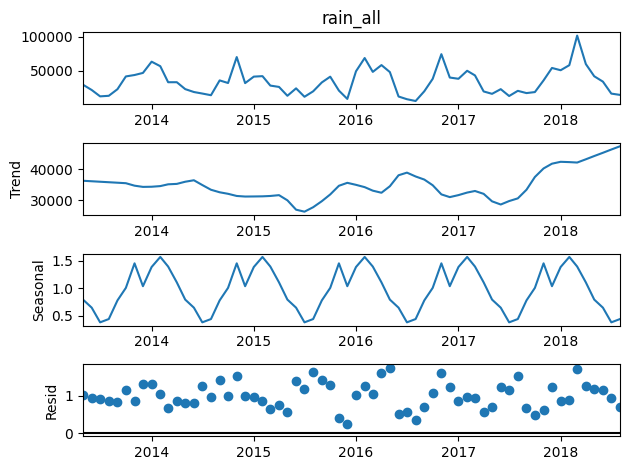

In [371]:
data_mult = seasonal_decompose(data['rain_all'], model='multiplicative', extrapolate_trend='freq')
data_mult.plot();

We calculate the mean a standard deviation of the resid for the multiplicative model:

In [373]:
data_mult.resid.mean(), data_mult.resid.std()

(1.0078112043406229, 0.35077453518676244)

In [374]:
reconstructed_df = pd.concat([
  data_mult.trend,
  data_mult.seasonal,
  data_mult.resid,
  data_mult.observed
], axis=1)
reconstructed_df.columns = ['trend', 'seasonal', 'residual', 'actual_values']
reconstructed_df.describe()

,trend,seasonal,residual,actual_values
count,64.000000,64.000000,64.000000,64.000000
mean,34953.415359,0.972703,1.007811,34067.514062
std,4663.545343,0.392973,0.350775,19266.121783
min,26368.429167,0.377209,0.236090,5660.700000
25%,31718.302083,0.645480,0.789545,18885.525000
50%,34612.260417,1.007320,0.975584,32614.300000
75%,36399.536014,1.389004,1.250980,44732.075000
max,47508.190438,1.573062,1.760371,102026.000000


Comparing both values, **multiplicative model is choosen because the standard deviation is smaller and it is centered in 1**.

### 3.- **Decompose** the ts, can you observe a **trend** or a **seasonal component**?

From the manual decomposition, we can say:

*   **Trend:** There is not a trend in the time series, there is no a behaviour of increasing or decreasing values in the series.
*   **Seasonality:** There are short-term cycles repeating in the series along the months, every year, with the natural weather seasons.

Therefore, in conclusion, we observe a seasonal component more than a trend.

### 4.- Is it **stationary**? If not, which **steps** did you apply to make it stationary?

**Original series:**

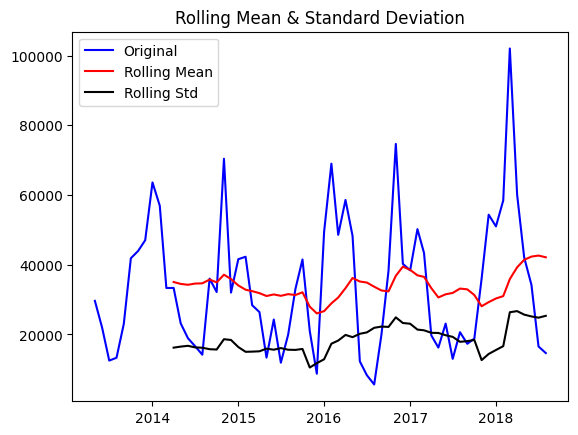

In [375]:
test_stationarity(data['rain_all'], 12)

We cannot see a clear trend, so the time series is stationary.

Getting the autocorrelation coefficient, as this is not so close to 1, we can say that the time series is not correlated to itself, so **it is stationary**.

In [376]:
data['rain_all'].autocorr()

0.5747791676202648

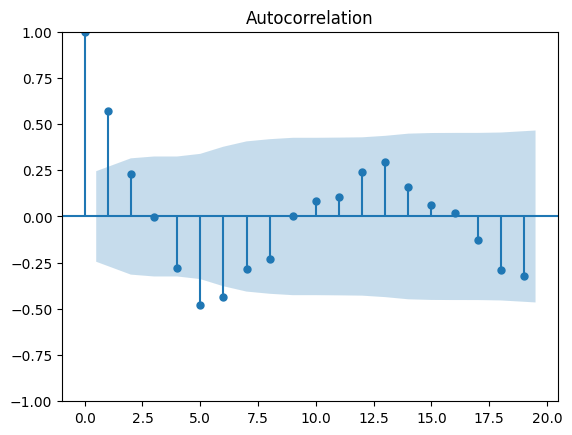

In [377]:
plot_acf(data['rain_all']);

The ACF values at most of the lags lie within the confidence intervals, so this is another indicator to say that the time series is stationary.

In [378]:
interpret_dftest(adfuller(data.rain_all), 0.05)

ADF Statistic: -5.477654
p-value: 0.000002
We can reject the null hypothesis. Time series is stationary
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594


From the test statistic, the ADF Statistic is smaller than the critical values, so we can reject the null hypothesis, and confirm that there is no a unit root, and the time series is stationary.

Even although the time series is already stationary, but we can test some methods to make a series stationary and look at the variations.

**Seasonal differencing (N=12):**

In [379]:
data['rain_all_seasonal_dif'] = data['rain_all'] - data['rain_all'].shift(12)
data.head(1)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rain_all_seasonal_dif
new_date,,,,,,
2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2,NaN


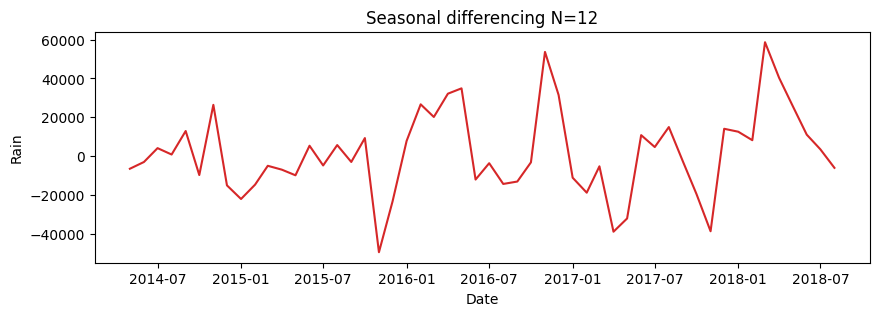

In [380]:
plot_df(data, x=data.index, y=data.rain_all_seasonal_dif, title='Seasonal differencing N=12', ylabel='Rain')

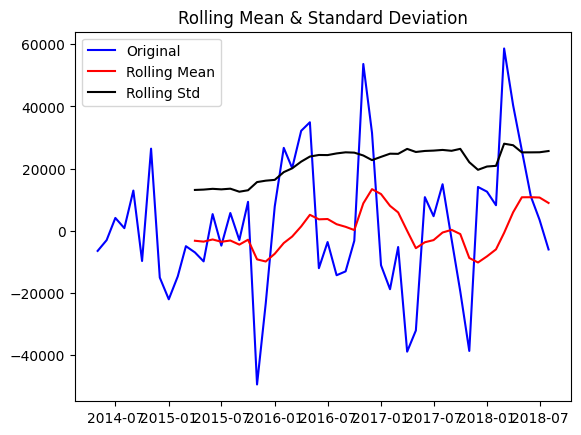

In [381]:
test_stationarity(data['rain_all_seasonal_dif'].dropna(), 12)

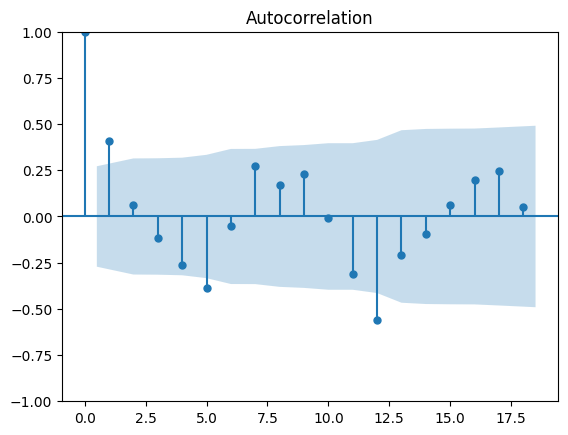

In [382]:
plot_acf(data['rain_all_seasonal_dif'].dropna());

In [384]:
interpret_dftest(adfuller(data.rain_all_seasonal_dif.dropna()), 0.05)

ADF Statistic: -2.886931
p-value: 0.046889
We can reject the null hypothesis. Time series is stationary
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


After a seasonal differencing (N=12), the time series continues stationary, but we can see a higher p-value, almost equal to the threshold. So the test statistic is better with the original time series.

**Normal differencing (N=1)**

In [385]:
data['rain_all_dif'] = data['rain_all'] - data['rain_all'].shift(1)
data.head(1)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rain_all_seasonal_dif,rain_all_dif
new_date,,,,,,,
2013-05-01,29634.3,6141.5,6955.3,9319.2,8591.2,NaN,NaN


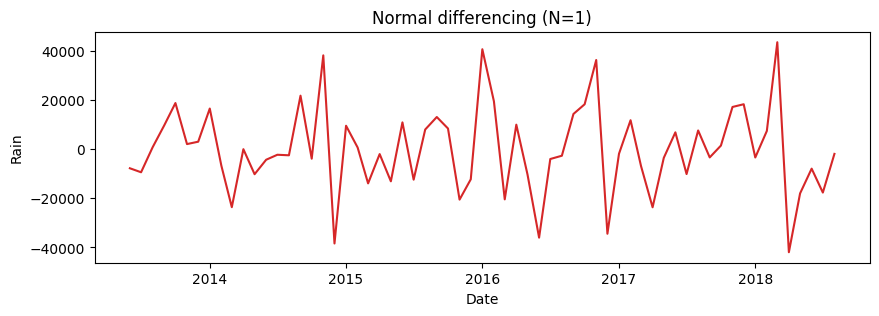

In [386]:
plot_df(data, x=data.index, y=data.rain_all_dif, title='Normal differencing (N=1)', ylabel='Rain')

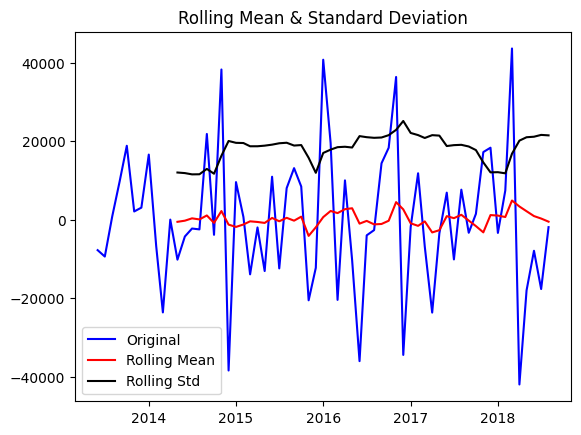

In [387]:
test_stationarity(data['rain_all_dif'].dropna(), 12)

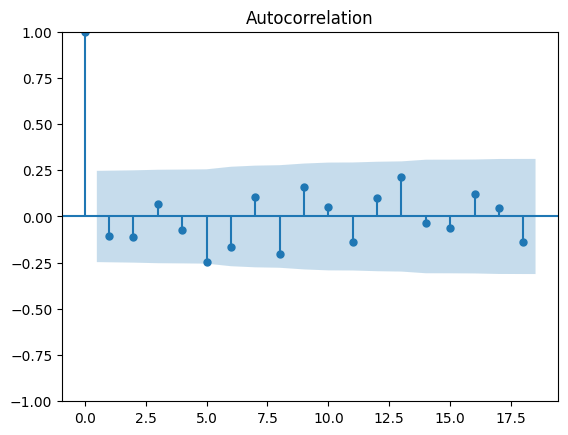

In [388]:
plot_acf(data['rain_all_dif'].dropna());

In [389]:
interpret_dftest(adfuller(data['rain_all_dif'].dropna()), 0.05)

ADF Statistic: -4.748529
p-value: 0.000068
We can reject the null hypothesis. Time series is stationary
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598


After a normal differencing (N=1), the time series continues stationary, and the final results are similar to the original series.

**Log and differencing**

In [390]:
data['rain_all_log_dif'] = np.log(data['rain_all']) - np.log(data['rain_all']).shift(1)

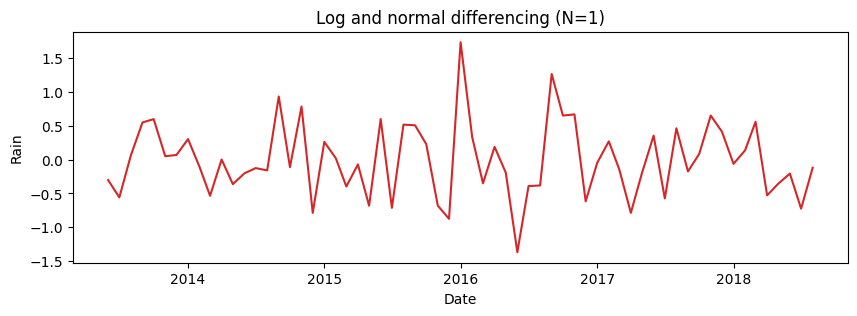

In [391]:
plot_df(data, x=data.index, y=data.rain_all_log_dif, title='Log and normal differencing (N=1)', ylabel='Rain')

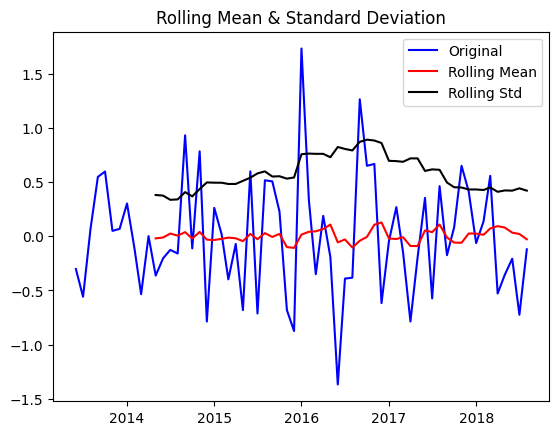

In [392]:
test_stationarity(data['rain_all_log_dif'], 12)

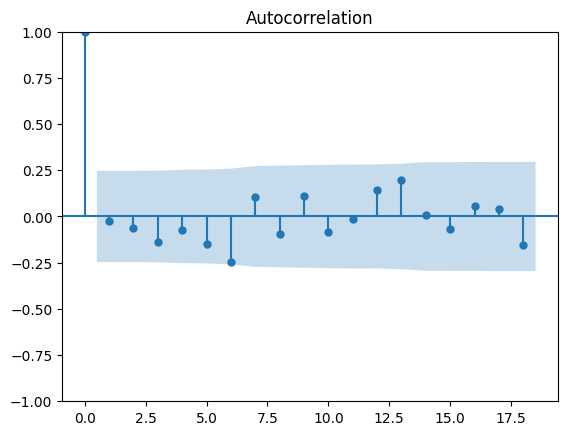

In [393]:
plot_acf(data['rain_all_log_dif'].dropna());

In [394]:
interpret_dftest(adfuller(data['rain_all_log_dif'].dropna()), 0.05)

ADF Statistic: -5.060807
p-value: 0.000017
We can reject the null hypothesis. Time series is stationary
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598


After a log normal differencing (N=1), the time series continues stationary, and the final results are similar to the original series.

In [395]:
data.describe()

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rain_all_seasonal_dif,rain_all_dif,rain_all_log_dif
count,64.000000,64.000000,64.000000,64.000000,64.000000,52.000000,63.000000,63.000000
mean,34067.514062,8216.856250,8401.934375,9504.381250,9700.815625,1637.748077,-237.530159,-0.011161
std,19266.121783,5184.353285,5542.373036,5233.150279,4676.360236,21967.623331,17833.001855,0.551405
min,5660.700000,1024.500000,801.900000,1334.400000,1806.300000,-49406.700000,-41933.500000,-1.368794
25%,18885.525000,4150.875000,3769.125000,5046.700000,6022.875000,-11299.425000,-10137.450000,-0.373381
50%,32614.300000,7813.250000,7924.700000,8791.500000,9362.550000,-2825.800000,-1972.600000,-0.072009
75%,44732.075000,11479.900000,12649.750000,12666.775000,12311.700000,12690.525000,9865.850000,0.343029
max,102026.000000,24350.900000,25285.300000,28059.500000,26929.100000,58651.200000,43575.700000,1.732456


Summary:

| Timeseries           | Rolling values                   | Correlogram                                 | ADF Test       |
| ---------------------|----------------------------------|---------------------------------------------|----------------|
| Original             | High variations                  | Most of lags under confident values         | Stationary |
| Seasonal dif. (N=12) | High variations                 | Most of lags under confident values | Stationary     |
| Normal dif. (N=1)    | Mean close to zero but variance is high | Values under confident values except lag=1         | Stationary     |
| Log + diff (N=1)     | Mean and variance close to zero | Values under confident values except lag=1         | Stationary     |

As the time series is originally stationary, we will move forward to the predictions with the original series.

### 5.- Build a **benchmark** model to predict the last 8 periods. Choose an **error measurement** and obtain the error of the prediction.

**Prediction for the last 8 periods:**

Check last 9 records to obtain the required date to split data in train and test.

In [396]:
data.tail(9)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rain_all_seasonal_dif,rain_all_dif,rain_all_log_dif
new_date,,,,,,,,
2017-12-01,54357.4,15074.8,13938.5,12639.8,13371.7,14110.9,18323.8,0.411129
2018-01-01,50999.6,11768.8,13418.7,13992.3,12200.1,12599.3,-3357.8,-0.063763
2018-02-01,58450.3,11652.1,14823.1,18041.7,14654.4,8235.9,7450.7,0.136359
2018-03-01,102026.0,23420.3,25285.3,28059.5,26929.1,58651.2,43575.7,0.557051
2018-04-01,60092.5,14305.5,12576.2,16327.1,17446.3,40356.1,-41933.5,-0.529343
2018-05-01,42106.1,7781.7,6800.1,13933.0,14194.8,25868.1,-17986.4,-0.355692
2018-06-01,34203.3,6657.4,6270.9,10628.7,11041.5,11081.9,-7902.8,-0.207870
2018-07-01,16561.4,2762.6,2897.9,4817.6,6240.4,3547.1,-17641.9,-0.725247
2018-08-01,14669.9,2365.9,1757.9,4890.7,6025.2,-5984.5,-1891.5,-0.121277


Obtain train and test

In [397]:
data_train = data[:'2017-12-01']
data_test = data['2018-01-01':]
data_train.shape, data_test.shape

((56, 8), (8, 8))

**Hat Mean: 0.54986**

Mean of the train model.

In [398]:
data_test['y_hat_mean'] = data_train['rain_all'].mean()
forecast_accuracy(data_test['y_hat_mean'], data_test['rain_all'])

<ipython-input-398-a4227050647b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_mean'] = data_train['rain_all'].mean()


{'MAPE': 0.5498658344665445}

**Hat Mean Last N: 0.54538**

Mean of the last N=12 periods.

In [399]:
data_test['y_hat_mean_last_n'] = data_train['rain_all'].rolling(12).mean().iloc[-1]
forecast_accuracy(data_test['y_hat_mean_last_n'], data_test['rain_all'])

<ipython-input-399-6143b367d490>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_mean_last_n'] = data_train['rain_all'].rolling(12).mean().iloc[-1]


{'MAPE': 0.5453853896152208}

**Naive: 0.82078**

Using the last value of the time series.

In [400]:
data_test['y_hat_naive'] = data_train['rain_all'].iloc[-1]
forecast_accuracy(data_test['y_hat_naive'], data_test['rain_all'])

<ipython-input-400-2f6a0c3bfb1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_naive'] = data_train['rain_all'].iloc[-1]


{'MAPE': 0.8207839908710125}

**Seasonal Naive: 0.96676**

Using the last value of the time series.

In [401]:
data_test['y_hat_seasonal_naive'] = data_train['rain_all'].iloc[-8:].values
forecast_accuracy(data_test['y_hat_seasonal_naive'], data_test['rain_all'])

<ipython-input-401-e754181d4ed3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_seasonal_naive'] = data_train['rain_all'].iloc[-8:].values


{'MAPE': 0.9667612199342771}

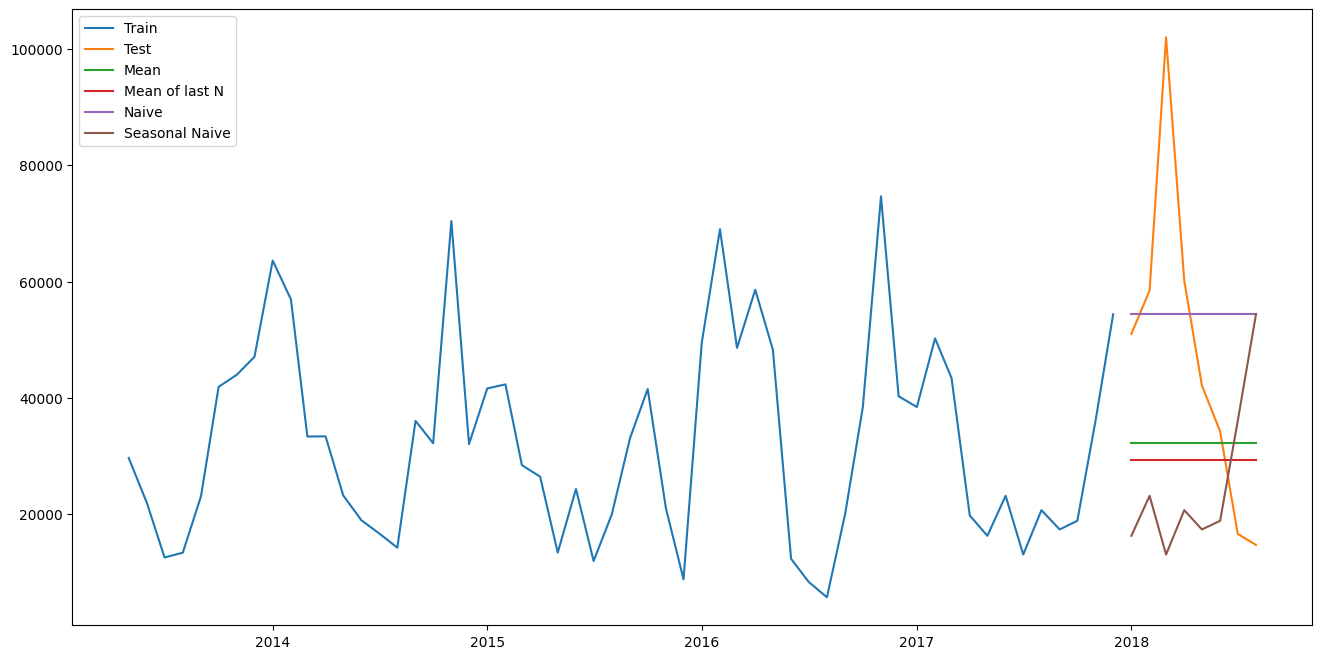

In [402]:
plt.figure(figsize=(16,8))
plt.plot(data_train['rain_all'], label='Train')
plt.plot(data_test['rain_all'], label='Test')
plt.plot(data_test['y_hat_mean'], label='Mean')
plt.plot(data_test['y_hat_mean_last_n'], label='Mean of last N')
plt.plot(data_test['y_hat_naive'], label='Naive')
plt.plot(data_test['y_hat_seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.show()

**Prediction for the last 12 periods:**

Due to the strong seasonality we make the prediction for 12 periods.

Check last 12 records to obtain the required date to split data in train and test.

In [404]:
data.tail(13)

,rain_all,rain_00_06,rain_06_12,rain_12_18,rain_18_24,rain_all_seasonal_dif,rain_all_dif,rain_all_log_dif
new_date,,,,,,,,
2017-08-01,20654.4,4081.5,3558.6,6431.7,6916.6,14993.7,7640.1,0.461880
2017-09-01,17329.0,4446.7,4537.2,4754.1,3751.9,-2690.0,-3325.4,-0.175547
2017-10-01,18820.2,4849.4,5537.8,4975.0,3661.1,-19511.0,1491.2,0.082549
2017-11-01,36033.6,9714.2,8442.6,7719.3,10380.1,-38623.7,17213.4,0.649521
2017-12-01,54357.4,15074.8,13938.5,12639.8,13371.7,14110.9,18323.8,0.411129
2018-01-01,50999.6,11768.8,13418.7,13992.3,12200.1,12599.3,-3357.8,-0.063763
2018-02-01,58450.3,11652.1,14823.1,18041.7,14654.4,8235.9,7450.7,0.136359
2018-03-01,102026.0,23420.3,25285.3,28059.5,26929.1,58651.2,43575.7,0.557051
2018-04-01,60092.5,14305.5,12576.2,16327.1,17446.3,40356.1,-41933.5,-0.529343


In [405]:
data_train_12 = data[:'2017-08-01']
data_test_12 = data['2017-09-01':]
data_train_12.shape, data_test_12.shape

((52, 8), (12, 8))

**Hat Mean: 0.54024**

Mean of the train model.

In [406]:
data_test_12['y_hat_mean'] = data_train_12['rain_all'].mean()
forecast_accuracy(data_test_12['y_hat_mean'], data_test_12['rain_all'])

<ipython-input-406-6dd5e5fbbae2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_12['y_hat_mean'] = data_train_12['rain_all'].mean()


{'MAPE': 0.5402390085147344}

**Hat Mean Last N: 0.54642**

Mean of the last N=12 periods.

In [407]:
data_test_12['y_hat_mean_last_n'] = data_train_12['rain_all'].rolling(12).mean().iloc[-1]
forecast_accuracy(data_test_12['y_hat_mean_last_n'], data_test_12['rain_all'])

<ipython-input-407-5b3410e25c01>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_12['y_hat_mean_last_n'] = data_train_12['rain_all'].rolling(12).mean().iloc[-1]


{'MAPE': 0.5464201820382353}

**Naive: 0.46603**

Using the last value of the time series.

In [408]:
data_test_12['y_hat_naive'] = data_train_12['rain_all'].iloc[-1]
forecast_accuracy(data_test_12['y_hat_naive'], data_test_12['rain_all'])

<ipython-input-408-a6bebf8d88a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_12['y_hat_naive'] = data_train_12['rain_all'].iloc[-1]


{'MAPE': 0.4660295909328951}

**Seasonal Naive: 0.47652**

Using the values of the last N=12 periods.

In [409]:
data_test_12['y_hat_seasonal_naive'] = data_train_12['rain_all'].iloc[-12:].values
forecast_accuracy(data_test_12['y_hat_seasonal_naive'], data_test_12['rain_all'])

<ipython-input-409-8a79b6e4b18b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_12['y_hat_seasonal_naive'] = data_train_12['rain_all'].iloc[-12:].values


{'MAPE': 0.4765227685594149}

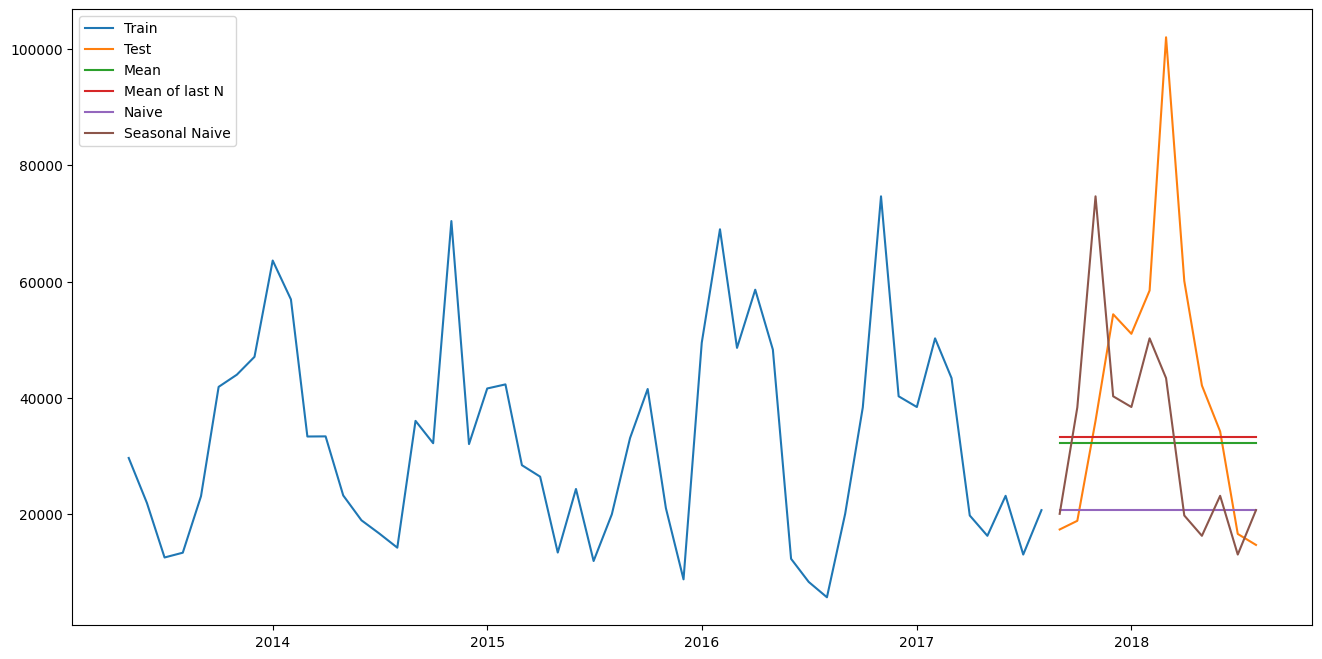

In [410]:
plt.figure(figsize=(16,8))
plt.plot(data_train_12['rain_all'], label='Train')
plt.plot(data_test_12['rain_all'], label='Test')
plt.plot(data_test_12['y_hat_mean'], label='Mean')
plt.plot(data_test_12['y_hat_mean_last_n'], label='Mean of last N')
plt.plot(data_test_12['y_hat_naive'], label='Naive')
plt.plot(data_test_12['y_hat_seasonal_naive'], label='Seasonal Naive')
plt.legend(loc='best')
plt.show()

Due to the strong seasonality we choose Seasonal Naive as a benchmark:

**Seasonal Naive 8 periods: 0.96676**

**Seasonal Naive 12 periods: 0.47652**

### 6.- Build an **AR** or a **MA** model. How does the **error** change?

First, let's obtain the potential orders for models AR and MA

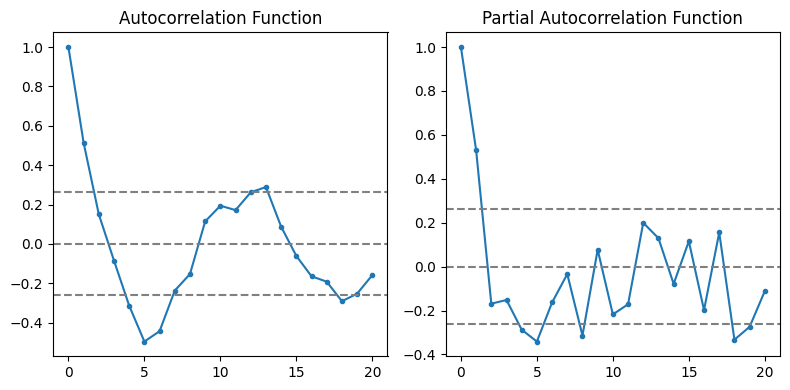

In [411]:
obtain_order_model(data_train['rain_all'].dropna())

In [412]:
period_forecast = 8

**AR**

PACF suggests order 12  or 15

* AR(1): MAPE=0.50005, AIC=1236.723
* AR(3): MAPE=0.52280, AIC=1239.939
* AR(6): MAPE=0.41515, AIC=1234.295
* AR(9): MAPE=0.36838, AIC=1235.605
* **AR(12): MAPE=0.33513, AIC=1236.723**
* AR(13): MAPE=0.34420, AIC=1238.063
* **AR(15): MAPE=0.32274, AIC=1241.730**
* AR(17): MAPE=0.34038, AIC=1243.406

In [413]:
model_ar = ARIMA(data_train['rain_all'].dropna(), order=(12, 0, 0))
model_ar_fitted = model_ar.fit()

In [414]:
forecast = model_ar_fitted.forecast(period_forecast, alpha=0.05)
data_test['y_hat_ar'] = forecast
forecast_accuracy(data_test['y_hat_ar'], data_test['rain_all'])

<ipython-input-414-dfdea8fa13c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_ar'] = forecast


{'MAPE': 0.3351305075450264}

                               SARIMAX Results                                
Dep. Variable:               rain_all   No. Observations:                   56
Model:                ARIMA(12, 0, 0)   Log Likelihood                -604.361
Date:                Mon, 26 Jun 2023   AIC                           1236.723
Time:                        21:52:25   BIC                           1265.078
Sample:                    05-01-2013   HQIC                          1247.716
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.216e+04   1434.667     22.419      0.000    2.94e+04     3.5e+04
ar.L1          0.4363      0.137      3.186      0.001       0.168       0.705
ar.L2         -0.1660      0.168     -0.990      0.3

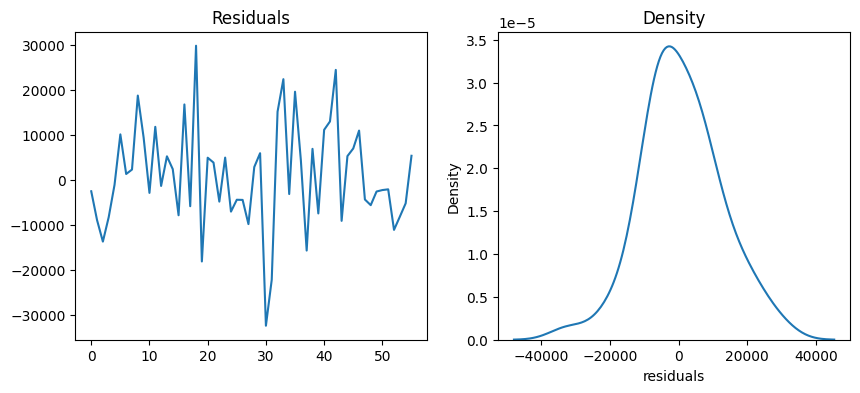

In [415]:
model_summary_results(model_ar_fitted)

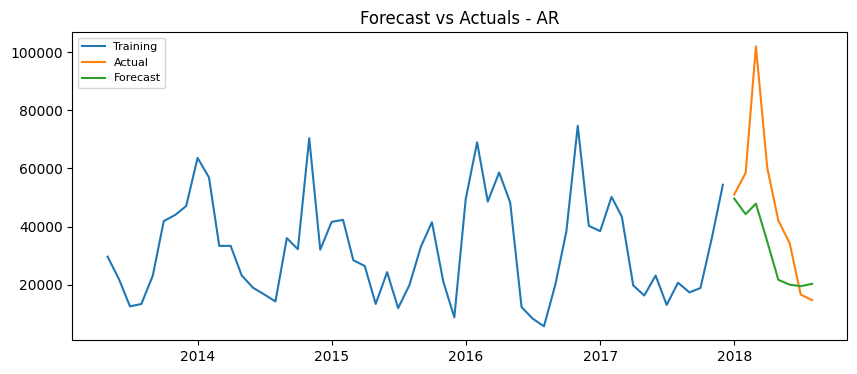

In [416]:
forecasting(model_ar_fitted, 12, data_test, 'Forecast vs Actuals - AR', 'rain_all')

**MA**

ACF suggests order = 12

* MA(1): MAPE=0.52708, AIC=1239.907
* MA(3): MAPE=0.50331, AIC=1243.679
* MA(5): MAPE=0.52458, AIC=1240.843
* **MA(6): MAPE=0.55266, AIC=1232.238**
* MA(10): MAPE=0.47528, AIC=1240.015
* MA(11): MAPE=0.46720, AIC=1239.681
* **MA(12): MAPE=0.46143, AIC=1236.622**

In [458]:
model_ma = ARIMA(data_train['rain_all'].dropna(), order=(0, 0, 6))
model_ma_fitted = model_ma.fit()

In [459]:
forecast = model_ma_fitted.forecast(period_forecast, alpha=0.05)
data_test['y_hat_ma'] = forecast
forecast_accuracy(data_test['y_hat_ma'], data_test['rain_all'])

<ipython-input-459-7a6f9b53367f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_ma'] = forecast


{'MAPE': 0.5526601309549772}

                               SARIMAX Results                                
Dep. Variable:               rain_all   No. Observations:                   56
Model:                 ARIMA(0, 0, 6)   Log Likelihood                -608.119
Date:                Mon, 26 Jun 2023   AIC                           1232.238
Time:                        22:00:54   BIC                           1248.440
Sample:                    05-01-2013   HQIC                          1238.519
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.216e+04   1344.090     23.930      0.000    2.95e+04    3.48e+04
ma.L1          0.5042      0.217      2.327      0.020       0.080       0.929
ma.L2          0.0066      0.282      0.023      0.9

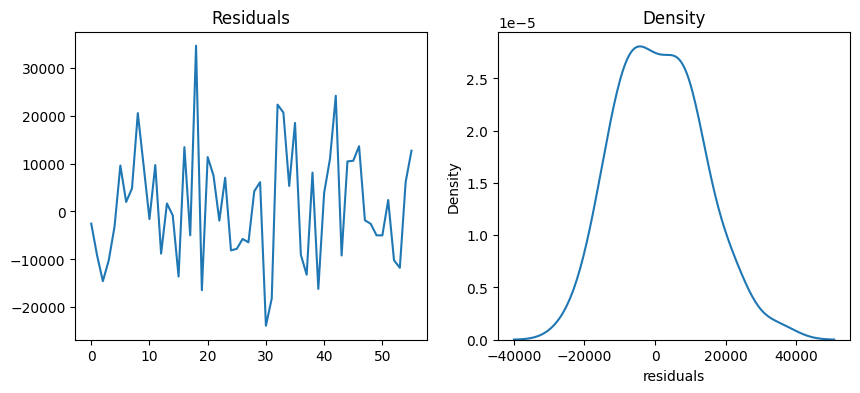

In [460]:
model_summary_results(model_ma_fitted)

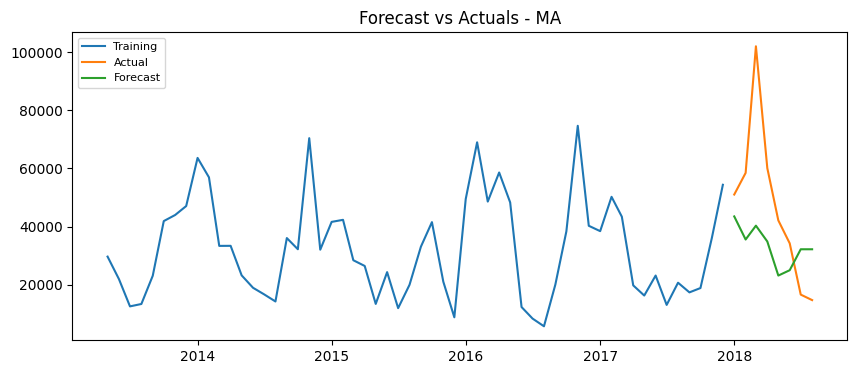

In [461]:
forecasting(model_ma_fitted, 12, data_test, 'Forecast vs Actuals - MA', 'rain_all')

**ARMA**

The combination of high orders for both models normally produce an error because it does not converge o there is a zero problem in someplace

* ARMA(1, 0, 1): MAPE=0.50644, AIC=1239.651
* **ARMA(1, 0, 3): MAPE=0.52071, AIC=1237.614**
* ARMA(9, 0, 9): MAPE=0.48291, AIC=1242.985
* ARMA(12, 0, 10): 0.38112, AIC=1254.573
* ARMA(12, 0, 12): MAPE=0.37819, AIC=3215262.020
* ARMA(15, 0, 12): MAPE=0.49782, AIC=2863436.254
* ARMA(17, 0, 12): MAPE=0.79723, AIC=3450207.604

In [421]:
model_arma = ARIMA(data_train['rain_all'].dropna(), order=(1, 0, 3))
model_arma_fitted = model_arma.fit()

In [422]:
forecast = model_arma_fitted.forecast(period_forecast, alpha=0.05)
data_test['y_hat_arma'] = forecast
forecast_accuracy(data_test['y_hat_arma'], data_test['rain_all'])

<ipython-input-422-9a83642f7198>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_arma'] = forecast


{'MAPE': 0.5207100565739617}

                               SARIMAX Results                                
Dep. Variable:               rain_all   No. Observations:                   56
Model:                 ARIMA(1, 0, 3)   Log Likelihood                -612.807
Date:                Mon, 26 Jun 2023   AIC                           1237.614
Time:                        21:54:01   BIC                           1249.766
Sample:                    05-01-2013   HQIC                          1242.325
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.216e+04    757.409     42.466      0.000    3.07e+04    3.36e+04
ar.L1          0.6915      0.198      3.499      0.000       0.304       1.079
ma.L1         -0.2743      0.328     -0.836      0.4

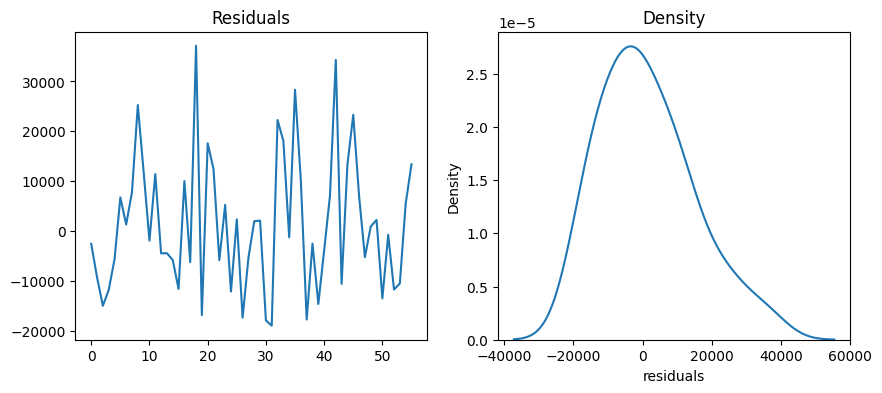

In [423]:
model_summary_results(model_arma_fitted)

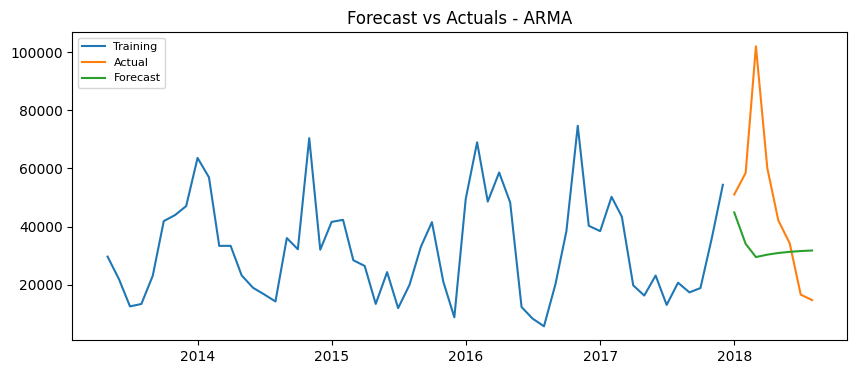

In [424]:
forecasting(model_arma_fitted, 12, data_test, 'Forecast vs Actuals - ARMA', 'rain_all')

### 7.- Build an **ARIMA** or **SARIMA** model. How does it affect to the **error**?

**ARIMA**

* ARIMA(1, 0, 1): MAPE=0.50644, AIC=1239.651
* **ARIMA(1, 1, 1): MAPE=0.49042, AIC=1222.853**
* ARIMA(2, 1, 1): MAPE=0.49834, AIC=1224.217
* ARIMA(3, 1, 1): MAPE=0.50114, AIC=1225.954
* ARIMA(1, 1, 2): MAPE=0.49632, AIC=1224.084
* ARIMA(2, 1, 2): MAPE=0.49433, AIC=1225.464
* ARIMA(2, 1, 3): MAPE=0.49650, AIC=1227.166

In [425]:
model_arima = ARIMA(data_train['rain_all'].dropna(), order=(1, 1, 1))
model_arima_fitted = model_arima.fit()

In [426]:
forecast = model_arima_fitted.forecast(period_forecast, alpha=0.05)
data_test['y_hat_arima'] = forecast
forecast_accuracy(data_test['y_hat_arima'], data_test['rain_all'])

<ipython-input-426-9c057adf5db6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_arima'] = forecast


{'MAPE': 0.4904176550444086}

                               SARIMAX Results                                
Dep. Variable:               rain_all   No. Observations:                   56
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -608.426
Date:                Mon, 26 Jun 2023   AIC                           1222.853
Time:                        21:54:24   BIC                           1228.875
Sample:                    05-01-2013   HQIC                          1225.182
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5675      0.189      2.997      0.003       0.196       0.939
ma.L1         -0.9845      0.262     -3.756      0.000      -1.498      -0.471
sigma2      2.882e+08    9.2e-10   3.13e+17      0.0

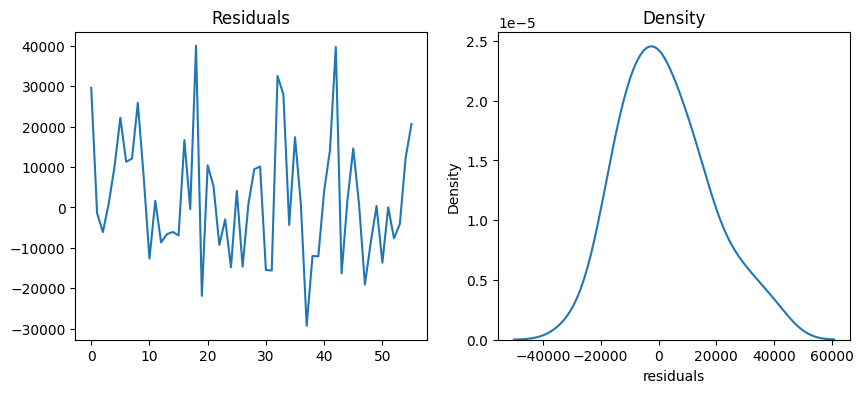

In [427]:
model_summary_results(model_arima_fitted)

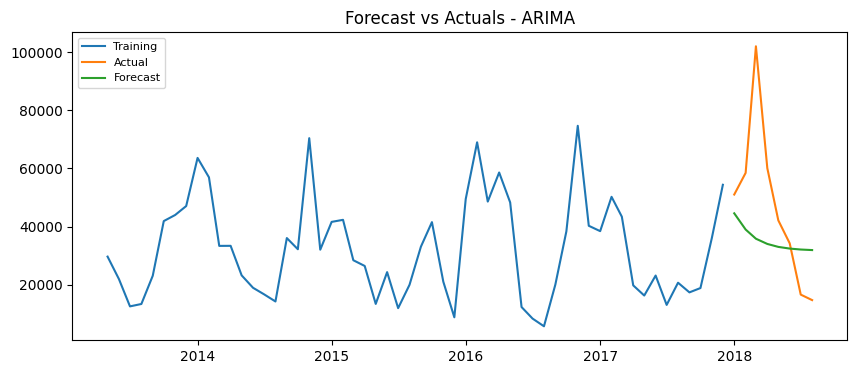

In [428]:
forecasting(model_arima_fitted, 12, data_test, 'Forecast vs Actuals - ARIMA', 'rain_all')

**SARIMA model**

* **ARIMA(1, 1, 1) (1, 1, 1, 12): MAPE=0.24773, AIC=960.690**
* ARIMA(2, 1, 1) (1, 1, 1, 12): MAPE=0.26079, AIC=975.817
* ARIMA(3, 1, 1) (1, 1, 1, 12): MAPE=0.29953, AIC=977.478
* ARIMA(2, 1, 2) (1, 1, 1, 12): MAPE=0.25625, AIC=966.142
* ARIMA(2, 1, 1) (2, 1, 1, 12): MAPE=0.26186, AIC=977.783
* ARIMA(2, 1, 1) (3, 1, 1, 12): MAPE=0.26286, AIC=979.778
* ARIMA(2, 1, 1) (2, 1, 2, 12): MAPE=0.26260, AIC=979.780


In [429]:
model_sarima = SARIMAX(data_train['rain_all'].dropna(), order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarima_fitted = model_sarima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [430]:
forecast = model_sarima_fitted.forecast(steps=6)
data_test['y_hat_sarima'] = forecast
forecast_accuracy(data_test.y_hat_sarima, data_test.rain_all)

<ipython-input-430-d0ec7810f033>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_sarima'] = forecast


{'MAPE': 0.24772887804604374}

                                     SARIMAX Results                                      
Dep. Variable:                           rain_all   No. Observations:                   56
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -475.345
Date:                            Mon, 26 Jun 2023   AIC                            960.690
Time:                                    21:54:50   BIC                            969.496
Sample:                                05-01-2013   HQIC                           963.938
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6324      0.212      2.981      0.003       0.217       1.048
ma.L1         -0.9988      4.875   

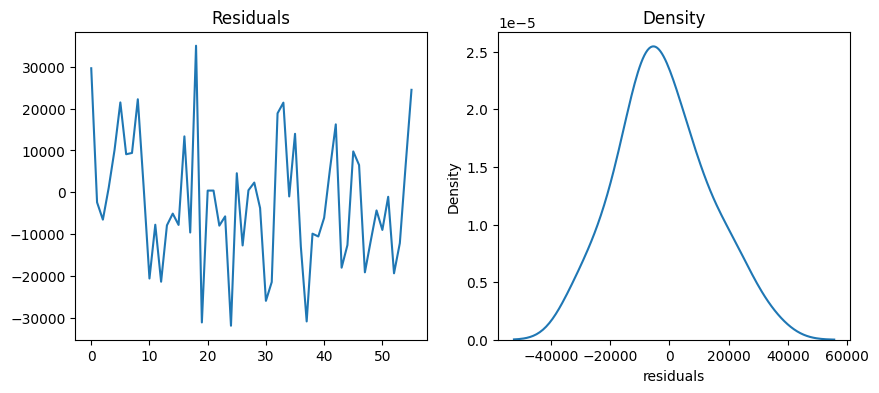

In [431]:
model_summary_results(model_sarima_fitted)

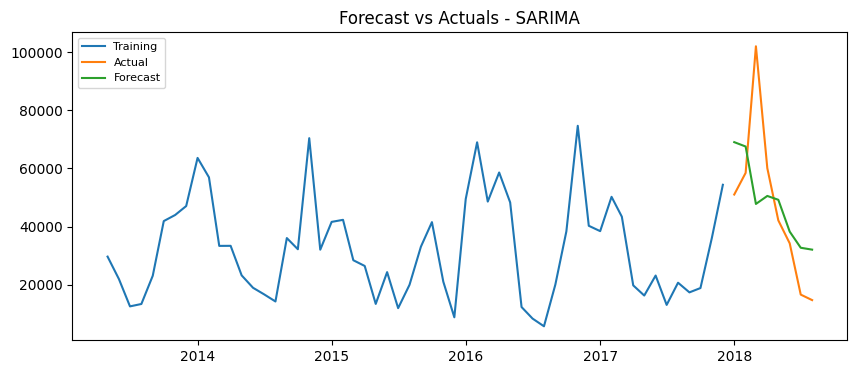

In [432]:
forecasting(model_sarima_fitted, 12, data_test, 'Forecast vs Actuals - SARIMA', 'rain_all')

### 8.- Use **auto_arima** functionality, how does it affect to the **error**?

**Autoarima witouth seasonality:**

* **Autoarima: ARIMA(1,0,0)(0,0,0)[0]: MAPE=0.28179, AIC=1250.766**

In [433]:
model_autoarima = pm.auto_arima(data_train.rain_all,
                                start_p=1, start_q=1, # initial values of p and q
                                test='adf',           # use adftest to find optimal 'd'
                                max_p=10, max_q=10,   # maximum p and q
                                m=0,                 # frequency of series, 1 means no seasonal data
                                d=None,               # let model determine 'd'
                                seasonal=False,       # No Seasonality
                                start_P=0,
                                D=0,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1252.586, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1337.178, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1250.766, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1306.436, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1252.572, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1254.204, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1238.650, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1254.163, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1239.136, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1239.651, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1240.313, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1241.487, Time=0.08 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.361 seconds


In [434]:
forecast, confidence = model_autoarima.predict(n_periods=period_forecast, return_conf_int=True)
data_test['y_hat_autoarima_1'] = forecast
forecast_accuracy(data_test['y_hat_autoarima_1'], data_test['rain_all'])

<ipython-input-434-01ecb96974bd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_autoarima_1'] = forecast


{'MAPE': 0.5001874031054776}

Checking the found best model with SARIMA:

In [435]:
model_sarima_auto_1 = SARIMAX(data_train['rain_all'].dropna(), order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))
model_sarima_auto_1_fitted = model_sarima_auto_1.fit()

In [436]:
forecast = model_sarima_auto_1_fitted.forecast(steps=6)
data_test['y_hat_auto_arima_1'] = forecast
forecast_accuracy(data_test.y_hat_auto_arima_1, data_test.rain_all)

<ipython-input-436-6fc4833a905e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_auto_arima_1'] = forecast


{'MAPE': 0.28178959804815906}

                               SARIMAX Results                                
Dep. Variable:               rain_all   No. Observations:                   56
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -623.383
Date:                Mon, 26 Jun 2023   AIC                           1250.766
Time:                        21:55:35   BIC                           1254.816
Sample:                    05-01-2013   HQIC                          1252.336
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9005      0.054     16.765      0.000       0.795       1.006
sigma2       2.67e+08   7.85e-12    3.4e+19      0.000    2.67e+08    2.67e+08
Ljung-Box (L1) (Q):                   0.61   Jarque-

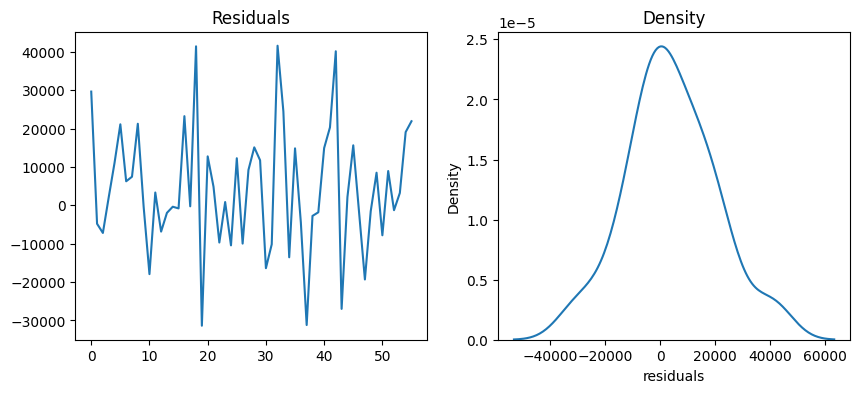

In [437]:
model_summary_results(model_sarima_auto_1_fitted)

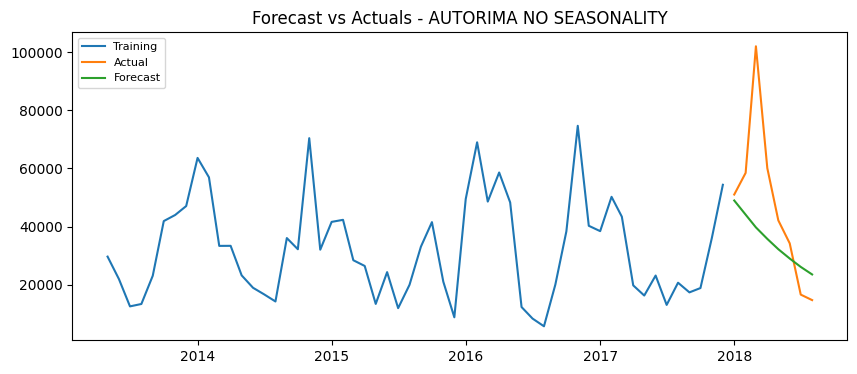

In [438]:
forecasting(model_sarima_auto_1_fitted, 12, data_test, 'Forecast vs Actuals - AUTORIMA NO SEASONALITY', 'rain_all')

**Autoarima with seasonality**

* **Autoarima:  ARIMA(1,0,0)(1,1,0)[12]: MAPE=0.29603, AIC=983.994**

In [439]:
model_autoarima_seasonality = pm.auto_arima(data_train.rain_all,
                                start_p=1, start_q=1, # initial values of p and q
                                test='adf',           # use adftest to find optimal 'd'
                                max_p=10, max_q=10,   # maximum p and q
                                m=12,                 # frequency of series, 1 means no seasonal data
                                d=None,               # let model determine 'd'
                                seasonal=True,        # For seasonal arima
                                start_P=0,
                                D=1,                  # For seasonal arima
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=991.838, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1002.583, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=986.546, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=990.171, Time=0.11 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1001.824, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1000.781, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=987.642, Time=0.19 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=987.758, Time=0.12 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=989.040, Time=0.09 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=989.637, Time=0.35 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=992.548, Time=0.04 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=988.236, Time=0.15 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=989.633, Time=0.11 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=988.531, Time=0.09 sec
 ARIMA(2,0,1)(1,1,0)[12] inter

In [440]:
forecast, confidence = model_autoarima_seasonality.predict(n_periods=period_forecast, return_conf_int=True)
data_test['y_hat_autoarima_2'] = forecast
forecast_accuracy(data_test['y_hat_autoarima_2'], data_test['rain_all'])

<ipython-input-440-751c7b04dc45>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_autoarima_2'] = forecast


{'MAPE': 0.29981274649994427}

Checking the found best model with SARIMA:

In [441]:
model_sarima_auto_2 = SARIMAX(data_train['rain_all'].dropna(), order=(1, 0, 0), seasonal_order=(1, 1, 0, 12))
model_sarima_auto_2_fitted = model_sarima_auto_2.fit()

In [442]:
forecast = model_sarima_auto_2_fitted.forecast(steps=6)
data_test['y_hat_auto_arima_2'] = forecast
forecast_accuracy(data_test.y_hat_auto_arima_2, data_test.rain_all)

<ipython-input-442-3bac39cc0b8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['y_hat_auto_arima_2'] = forecast


{'MAPE': 0.2960309657066763}

                                     SARIMAX Results                                      
Dep. Variable:                           rain_all   No. Observations:                   56
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                -488.997
Date:                            Mon, 26 Jun 2023   AIC                            983.994
Time:                                    21:56:29   BIC                            989.346
Sample:                                05-01-2013   HQIC                           985.979
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5332      0.251      2.121      0.034       0.040       1.026
ar.S.L12      -0.6562      0.193   

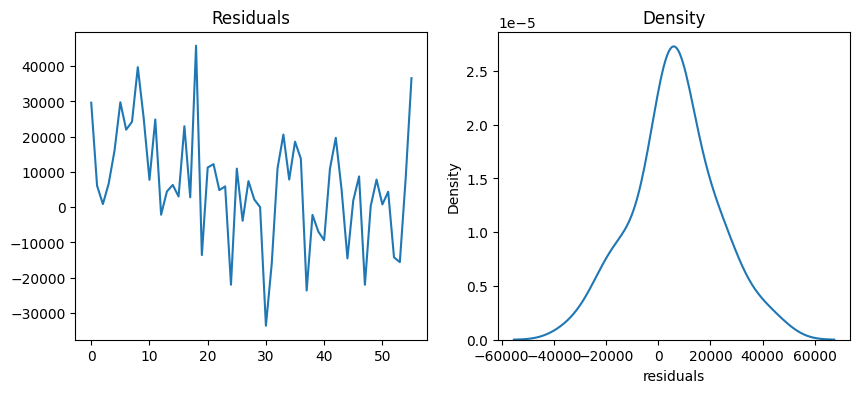

In [443]:
model_summary_results(model_sarima_auto_2_fitted)

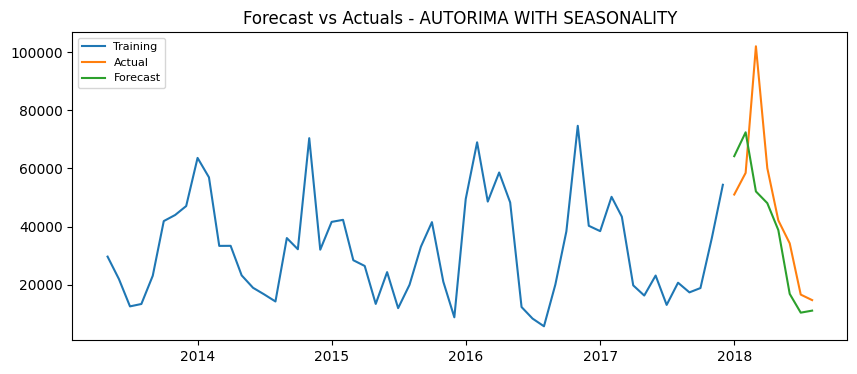

In [444]:
forecasting(model_sarima_auto_2_fitted, 12, data_test, 'Forecast vs Actuals - AUTORIMA WITH SEASONALITY', 'rain_all')

### 9.- Build a model with **Prophet**, does the **error** increase or decrease?

**With basic prophet model:**

*   **MAPE: 0.29485**


In [445]:
data_prophet = pd.DataFrame()
data_prophet['ds'] = data.index
data_prophet['y'] = data['rain_all'].values
data_prophet.head()

,ds,y
0,2013-05-01,29634.3
1,2013-06-01,21886.2
2,2013-07-01,12508.8
3,2013-08-01,13331.8
4,2013-09-01,23053.8


In [446]:
model_prophet_basic = Prophet(interval_width=0.95,
  yearly_seasonality = True,
  weekly_seasonality = False,
  daily_seasonality = False)

model_prophet_basic.fit(data_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcq1tee15/df0ws5fs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcq1tee15/8duqb01s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65814', 'data', 'file=/tmp/tmpcq1tee15/df0ws5fs.json', 'init=/tmp/tmpcq1tee15/8duqb01s.json', 'output', 'file=/tmp/tmpcq1tee15/prophet_modelyckvjlly/prophet_model-20230626215703.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:57:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:57:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [447]:
future_dates = model_prophet_basic.make_future_dataframe(periods=12, freq='MS')
forecast = model_prophet_basic.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']].tail(1)

,ds,yhat,yhat_lower,yhat_upper,trend
75,2019-08-01,22850.320093,-53.587381,47065.19366,45268.72212


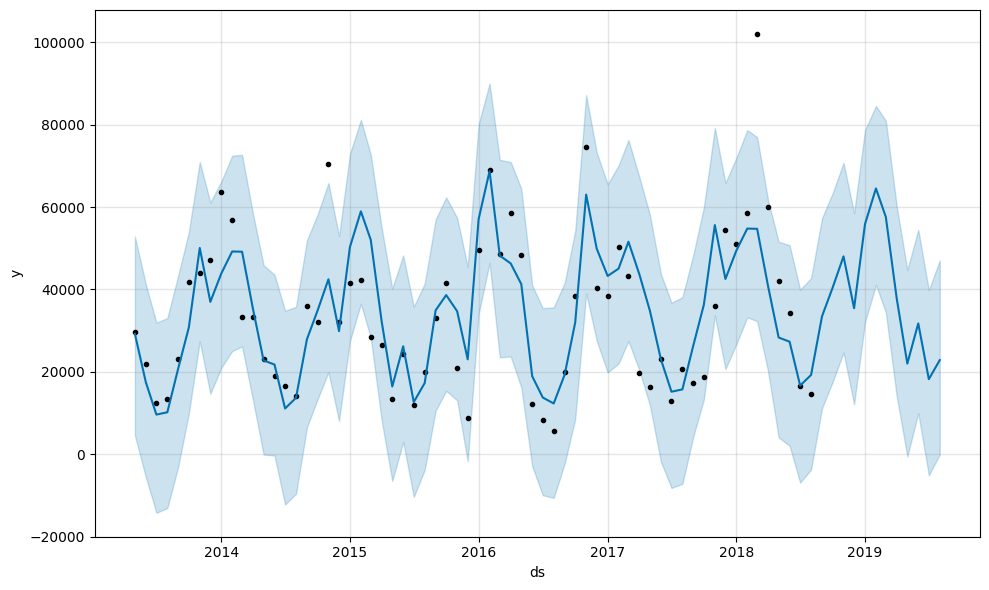

In [448]:
model_prophet_basic.plot(forecast, uncertainty=True);

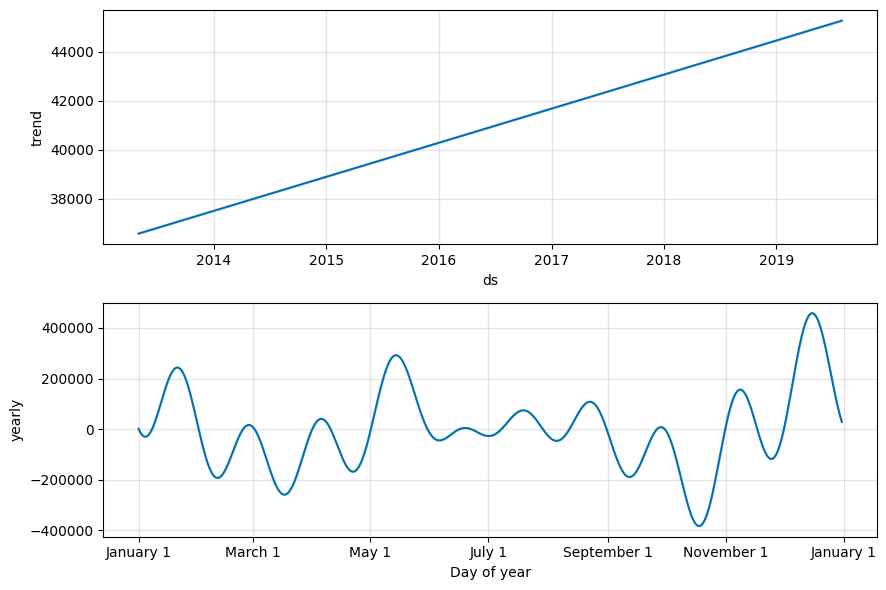

In [449]:
model_prophet_basic.plot_components(forecast);

Calculate MAPE between observed and predicted values:

In [450]:
df_merge = pd.merge(data_prophet, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head(1)

,ds,yhat_lower,yhat_upper,yhat,y
0,2013-05-01,4553.695731,52847.555862,29222.001874,29634.3


In [451]:
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
forecast_accuracy(y_pred, y_true)

{'MAPE': 0.2948468846371084}

**With a prophet model from Fourier Series:**

*   **MAPE: 0.29850**

In [452]:
model_prophet_seasonal = Prophet(interval_width=0.95,
  yearly_seasonality = True,
  weekly_seasonality = False,
  daily_seasonality = False)

model_prophet_seasonal.add_seasonality(name='monthly',
  period=30.5,
  fourier_order=7)

model_prophet_seasonal.fit(data_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpcq1tee15/m3ygkl9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcq1tee15/swzkgvxv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25115', 'data', 'file=/tmp/tmpcq1tee15/m3ygkl9k.json', 'init=/tmp/tmpcq1tee15/swzkgvxv.json', 'output', 'file=/tmp/tmpcq1tee15/prophet_modelxfnyuemf/prophet_model-20230626215755.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
21:57:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:57:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [453]:
future_dates = model_prophet_seasonal.make_future_dataframe(periods=12, freq='MS')
forecast_seasonal = model_prophet_seasonal.predict(future_dates)

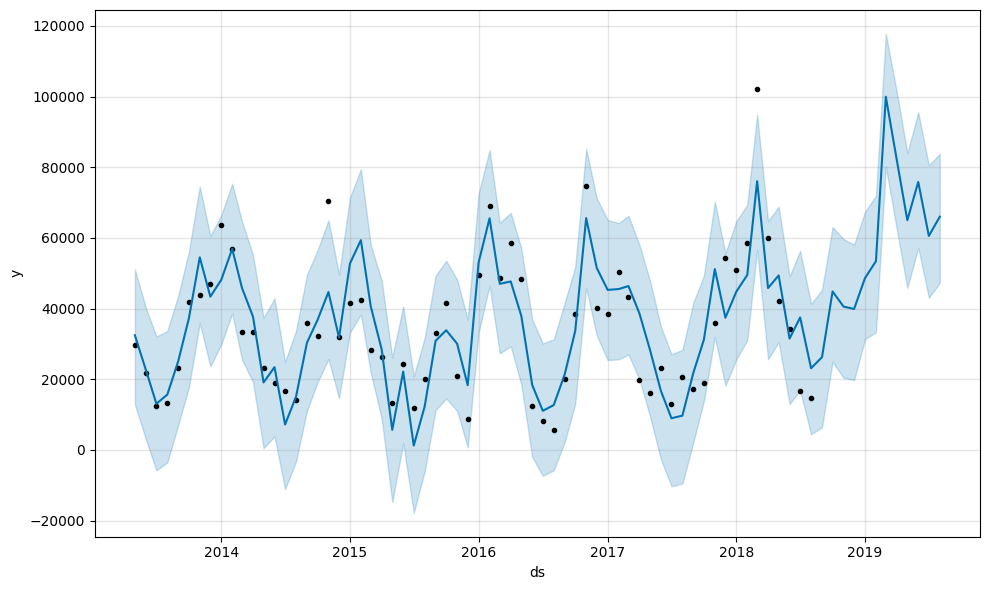

In [454]:
model_prophet_seasonal.plot(forecast_seasonal, uncertainty=True);

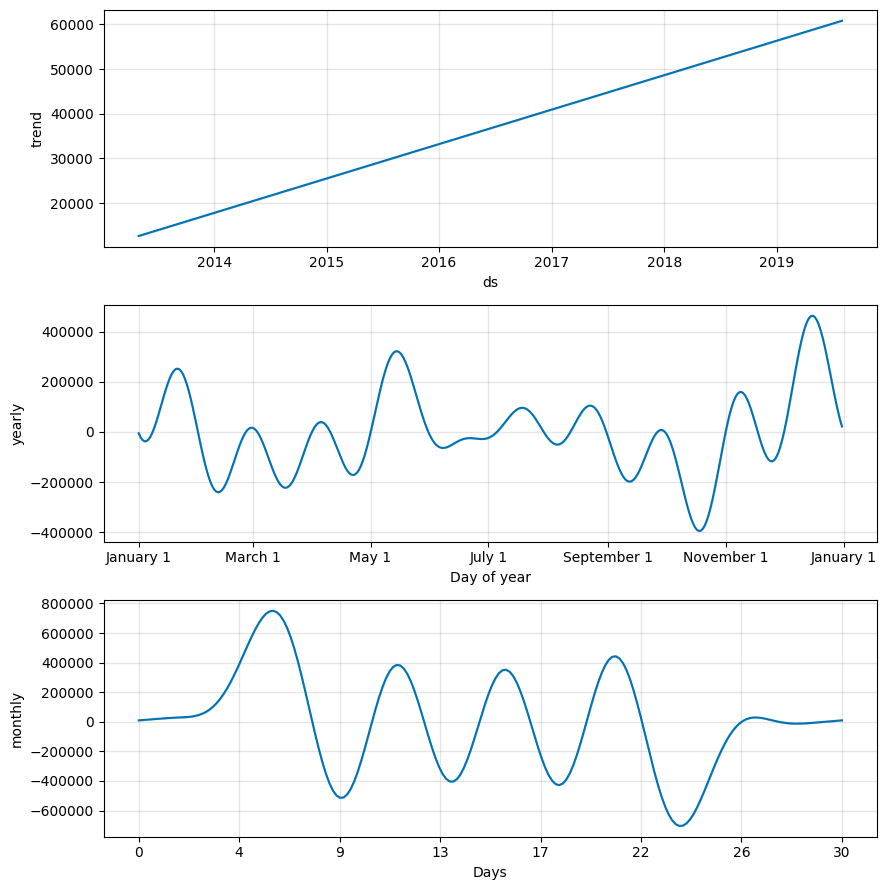

In [455]:
model_prophet_seasonal.plot_components(forecast_seasonal);

In [456]:
df_merge = pd.merge(data_prophet, forecast_seasonal[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge = df_merge[['ds','yhat_lower','yhat_upper','yhat','y']]
df_merge.head(1)

,ds,yhat_lower,yhat_upper,yhat,y
0,2013-05-01,12802.505227,51049.518707,32433.013022,29634.3


In [457]:
y_true = df_merge['y'].values
y_pred = df_merge['yhat'].values
forecast_accuracy(y_pred, y_true)

{'MAPE': 0.29849952405387115}

# Summary

If we collect the best solution for each case:
* Seasonal Naive 12 periods: MAPE=0.47652
* AR(12): MAPE=0.33513, AIC=1236.723
* MA(6): MAPE=0.55266, AIC=1232.238
* ARMA(1, 0, 3): MAPE=0.52071, AIC=1237.614
* ARIMA(1, 1, 1): MAPE=0.49041, AIC=1222.853
* ARIMA(1, 1, 1) (1, 1, 1, 12): MAPE=0.24773, AIC=960.690
* ARIMA(1,0,0)(0,0,0)[0]: MAPE=0.28179, AIC=1250.766 (autoarima)
* **ARIMA(1,0,0)(1,1,0)[12]: MAPE=0.29603, AIC=983.994 (autoarima seasonality)**
* PROHET BASIC: MAPE=0.29485
* PROHET FOURIER SERIES: MAPE=0.29850

The best model could be AUTOARIMA with Seasonality, with a lower MAPE (Mean Absolute Percentage Error), and a lower AIC.